In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


In [4]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Berlin_dfm.csv',
                   encoding='utf8')

In [5]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,review_count,reviews,room_type
0,0,8.0,10.0,10.0,0.057015,1206,30,1.0,Charlottenburg-Wilmersdorf,5.0,80.0,9,11850,1,Entire home/apt
1,1,1.0,2.0,2.0,0.057015,1206,30,3.0,Charlottenburg-Wilmersdorf,4.0,104.0,9,11850,1,Entire home/apt


In [6]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [8]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)



In [9]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + review_count + reviews + room_type -1'

In [10]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [12]:
X_train.shape, X_test.shape

((10357, 24), (4439, 24))

In [13]:
reg_scores = cross_val_score(LinearRegression(), X_train, y_train, cv= 10)
print reg_scores, np.mean(reg_scores)

[  4.63961004e-01   4.77565082e-01   5.18575346e-01   4.87901637e-01
   4.64026613e-01   4.57695093e-01   4.33980184e-01   4.95769167e-01
   4.69864297e-01  -1.00081355e+05] -10007.7085648


In [14]:
linreg = LinearRegression().fit(X_train, y_train)

In [15]:
from sklearn.tree import DecisionTreeRegressor


In [16]:
predictions = cross_val_predict(linreg, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.454721875807


In [17]:
residuals = y_test - predictions
residuals

array([-0.27532916,  1.08556666,  0.10240275, ..., -0.36073833,
       -0.43348557, -0.42499684])

In [18]:
np.mean(predictions)


4.0353046045257095

In [19]:
#linmod.coef_

In [20]:
print np.mean(y_train), np.mean(y_test)

4.04477281012 4.03548120798


In [21]:
Xn = StandardScaler().fit_transform(X)

In [22]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [24]:
# rf = RandomForestRegressor()

# rf_params = {
#     'n_estimators':[500],
#     'max_depth':[5,8,15,25,30,None],
#     'min_samples_split':[2,4,8,16,32,64,128],
#     'max_features':[None, 'sqrt', 'log2']
# }

# rf_gs = GridSearchCV(rf, rf_params, cv= 10, verbose=1, n_jobs=-1)
# rf_gs.fit(Xn_train, y_train)

In [25]:
# print rf_gs.best_params_
# rf_best = rf_gs.best_estimator_

# rf_scores = cross_val_score(rf_best, Xn_train, y_train, cv=10)
# print rf_scores
# print np.mean(rf_scores), np.std(rf_scores)

In [26]:
import time

In [27]:
start_time = time.time()

rf = RandomForestRegressor(max_features=None, min_samples_split=128, n_estimators=500, max_depth=30)

y_pred = rf.fit(Xn_train,y_train).predict(Xn_test)
r2_score = metrics.r2_score(y_test, y_pred)
print("r^2 on test data : %f" % r2_score)

print("--- %s seconds ---" % (time.time() - start_time))


r^2 on test data : 0.512212
--- 8.07690906525 seconds ---


In [28]:
#rf_best.feature_importances_

In [29]:
feature_imp = {}
for i, value in enumerate(rf.feature_importances_):
    feature_imp[i] = value

feature_imp = pd.DataFrame(feature_imp.items(), columns=['item_no','imp'])
feature_imp.head(2)

,item_no,imp
0,0,0.001357
1,1,0.000231


In [30]:
feature_name = {}
for i, value in enumerate(X_train.columns):
    feature_name[i] = value

feature_name = pd.DataFrame(feature_name.items(), columns=['item_no','name'])
feature_name.head(2)

,item_no,name
0,0,neighborhood[Charlottenburg-Wilmersdorf]
1,1,neighborhood[Friedrichshain-Kreuzberg]


In [31]:
feature_val = feature_name.merge(feature_imp, on='item_no')
feature_val.sort_values('imp',inplace=True,ascending=False,axis=0)

In [32]:
feature_val = feature_val.reset_index(drop=True)

In [33]:
feature_val.head(25)

,item_no,name,imp
0,12,room_type[T.Private room],0.575089
1,15,bedrooms,0.190501
2,19,minstay,0.063414
3,14,bathrooms,0.046879
4,13,room_type[T.Shared room],0.036294
5,16,dist_arprt,0.020769
6,23,reviews,0.020646
7,20,overall_satisfaction,0.011457
8,22,review_count,0.008099
9,17,host_count,0.006708


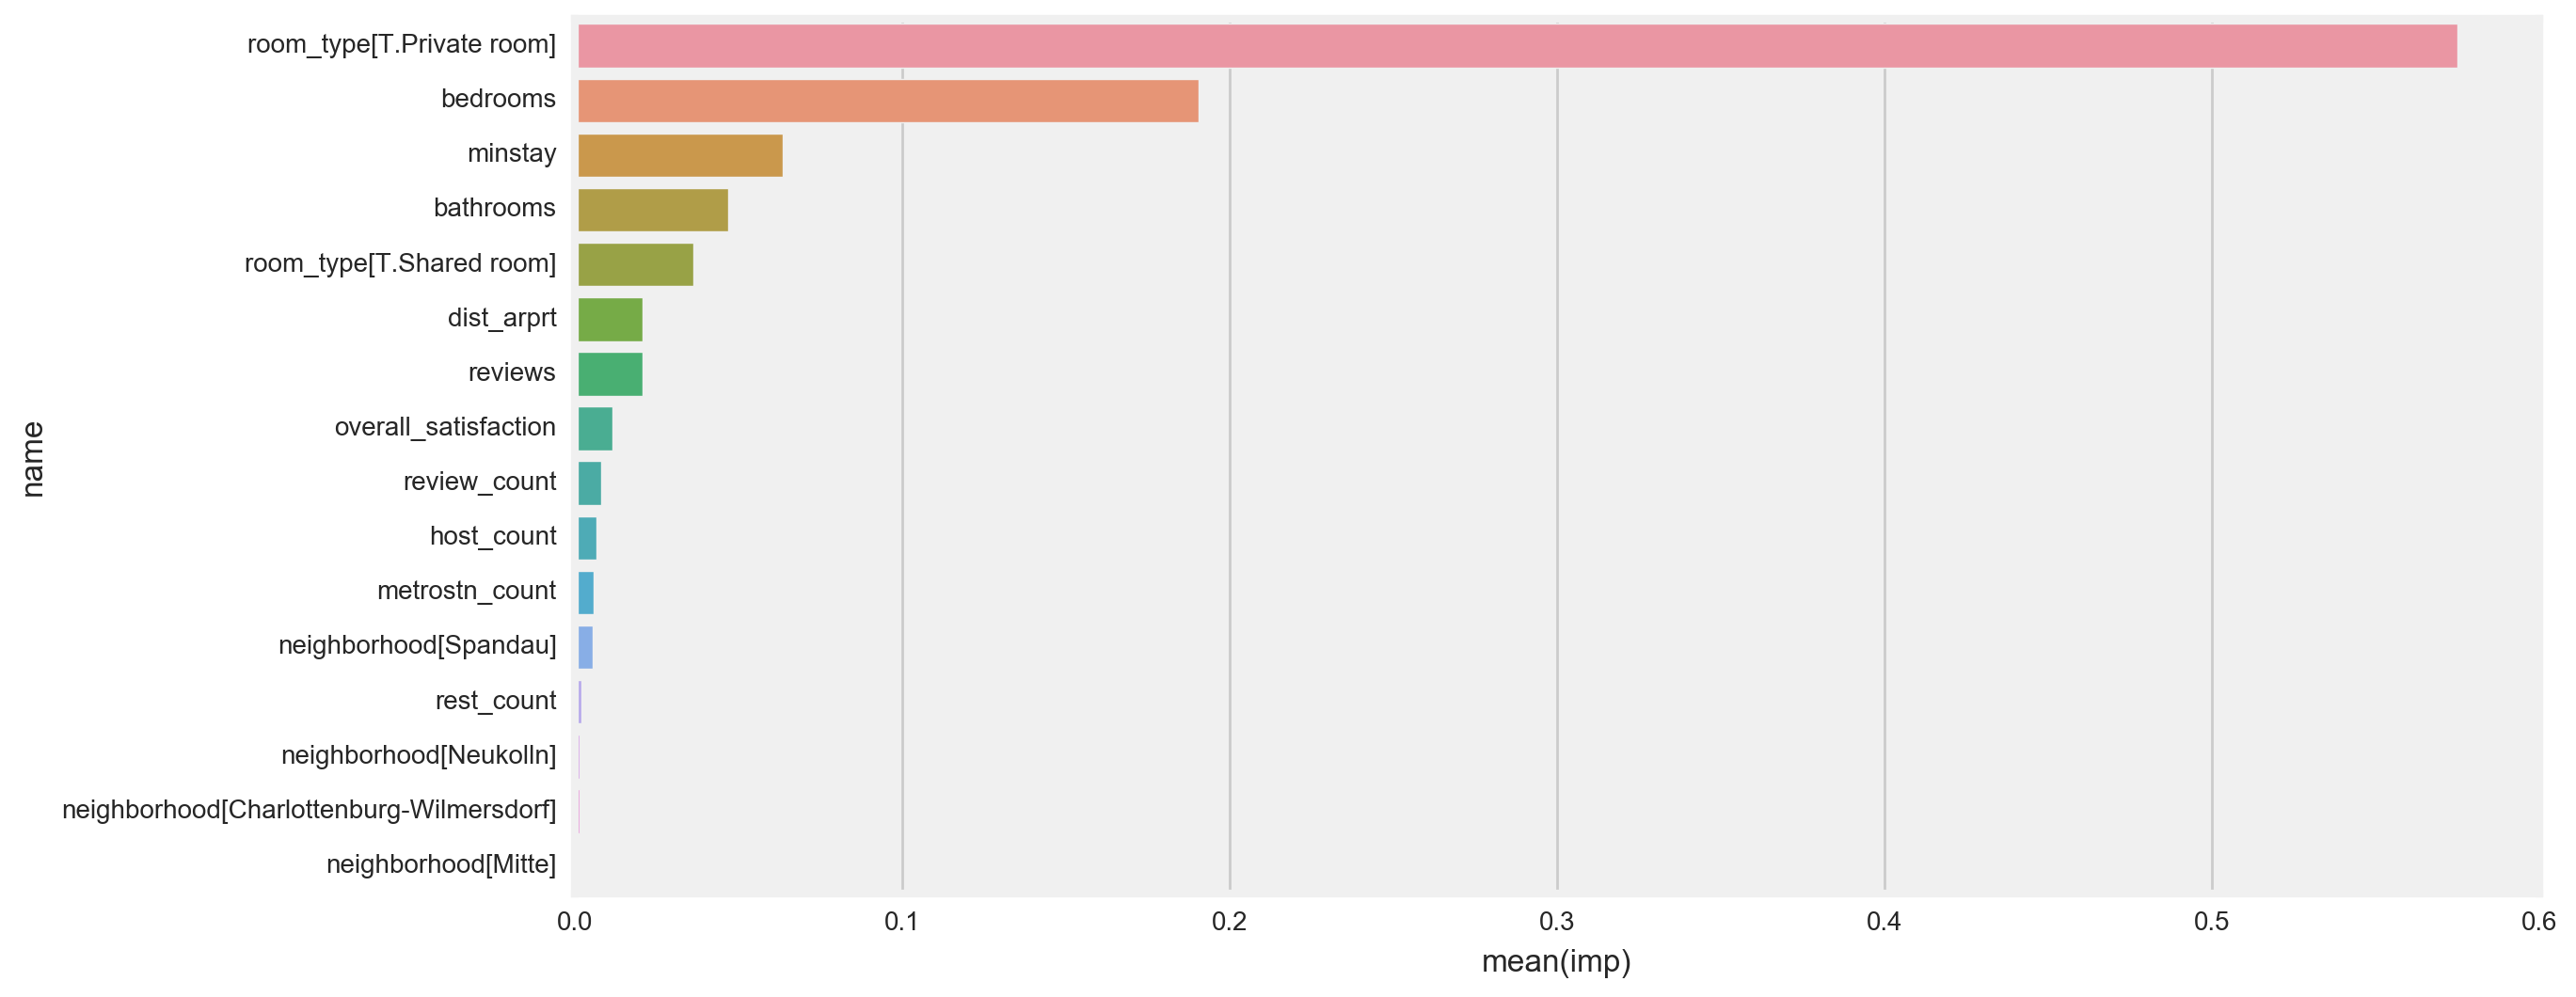

In [34]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(y = feature_val.loc[0:15,:].name, x = feature_val.loc[0:15,:].imp, data=feature_val.loc[0:15,:],orient=""
           )
plt.show()